In [1]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:00<00:00, 3.28GB/s]


In [5]:
%pip uninstall torch torchvision
%pip install torch torchvision

Found existing installation: torch 2.7.1
Uninstalling torch-2.7.1:
  Would remove:
    /opt/anaconda3/bin/torchfrtrace
    /opt/anaconda3/bin/torchrun
    /opt/anaconda3/lib/python3.12/site-packages/functorch/*
    /opt/anaconda3/lib/python3.12/site-packages/torch-2.7.1.dist-info/*
    /opt/anaconda3/lib/python3.12/site-packages/torch/*
    /opt/anaconda3/lib/python3.12/site-packages/torchgen/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os


device = "mps" if torch.backends.mps.is_available() else "cpu"

print(device)

mps


In [7]:
image_path = []
labels = []

for i in os.listdir("animal-faces/afhq"):

    for label in os.listdir(f"animal-faces/afhq/{i}"):

        for image in os.listdir(f"animal-faces/afhq/{i}/{label}"):
            image_path.append(f"animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])

data_df.head()

,image_path,labels
0,animal-faces/afhq/train/cat/pixabay_cat_000455...,cat
1,animal-faces/afhq/train/cat/pixabay_cat_001993...,cat
2,animal-faces/afhq/train/cat/pixabay_cat_004633...,cat
3,animal-faces/afhq/train/cat/pixabay_cat_002242...,cat
4,animal-faces/afhq/train/cat/pixabay_cat_002524...,cat


In [8]:
print(data_df["labels"].unique())

['cat' 'dog' 'wild']


In [18]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [19]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ]
)

In [20]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [22]:
train_dataset = CustomImageDataset(train, transform=transform)
val_dataset = CustomImageDataset(val, transform=transform)
test_dataset = CustomImageDataset(test, transform=transform)

In [ ]:
train_dataset.__getitem__(2)

In [25]:
label_encoder.inverse_transform([0])

array(['cat'], dtype=object)

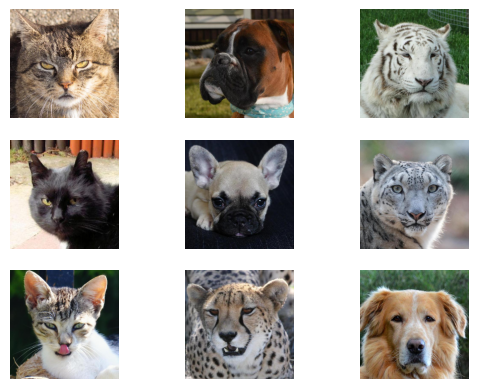

In [26]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

In [27]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [28]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=3, padding=1
        )  # takes image with 3 channels(R,G,B). Create 32 feature maps by scanning image with a 3x3 filter.
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=3, padding=1
        )  # take those 32 and turn into 64 feature maps for complex patterns
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)  # reduce the image size by half(pick most imp values)

        self.relu = nn.ReLU()  # adds non-linearity. Helps network to learn complex things, not just str lines

        self.flatten = nn.Flatten()  # turn feature maps into 1D.
        self.linear = nn.Linear((128 * 16 * 16), 128)  # fully connected layer to get 128 number output

        self.output = nn.Linear(128, len(data_df["labels"].unique()))  # number for each class

    def forward(self, x):
        x = self.conv1(x)   # 32,128,128
        x = self.pooling(x) # 32,64,64
        x = self.relu(x)

        x=self.conv2(x)     # 64,64,64
        x= self.pooling(x)  # 64,32,32
        x-self.relu(x)

        x=self.conv3(x)     # 128, 32, 32
        x=self.pooling(x)   # 128, 16, 16
        x=self.relu(x)

        x = self.flatten(x)
        x=self.linear(x)
        x=self.output(x)
        
        return x

In [46]:
model = Net().to(device)

In [52]:
from torchsummary import summary


model = model.to('cpu')
summary(model, input_size=(3,128,128))
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [53]:
criterion= nn.CrossEntropyLoss()
optimizer =Adam(model.parameters(), lr=LR)

In [82]:
total_loss_train_plot= []
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

for epoch in range(EPOCHS):

  total_acc_train=0
  total_loss_train=0
  total_acc_val=0
  total_loss_val=0


  for inputs, labels in train_loader:

    optimizer.zero_grad()
    outputs= model(inputs)
    train_loss = criterion(outputs, labels)
    #print("Train loss: ", train_loss.item())
    total_loss_train+=train_loss.item()
    train_loss.backward() 

    #Compute the gradients of the loss with respect to all model parameters.
    #.backward() goes through that graph and finds how to adjust weights to reduce the loss.
    #These gradients are used later by optimizer.step() to update the weights.

    train_acc = (torch.argmax(outputs, axis=1)==labels).sum().item()

    #For each sample, pick the class with the highest predicted score (the predicted label).
    # ==labels Compare the predicted labels to the true labels → you get a tensor of True/False values.

    total_acc_train+=train_acc
    optimizer.step()

  with torch.no_grad(): # use model without optimization
    for inputs, labels in val_loader:
      outputs=model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val+= val_loss.item()
      
      val_acc = (torch.argmax(outputs, axis=1)==labels).sum().item()
      total_acc_val += val_acc

  
  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))

  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100,4))
  total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__())*100,4))

  print(f'''
    Epoch: {epoch+1}/{EPOCHS}, Train loss: {round(total_loss_train/1000,4)} Train Accuracy {round((total_acc_train/train_dataset.__len__())*100,4)}
Validation loss: {round(total_loss_val/1000,4)}  Validation Accuracy; {round((total_acc_val/val_dataset.__len__())*100,4)}
''')


    Epoch: 1/10, Train loss: 0.0107 Train Accuracy 99.5217
Validation loss: 0.0179  Validation Accuracy; 96.4463


    Epoch: 2/10, Train loss: 0.0085 Train Accuracy 99.5926
Validation loss: 0.0221  Validation Accuracy; 96.1157


    Epoch: 3/10, Train loss: 0.0055 Train Accuracy 99.6989
Validation loss: 0.0269  Validation Accuracy; 95.8678


    Epoch: 4/10, Train loss: 0.0053 Train Accuracy 99.814
Validation loss: 0.0196  Validation Accuracy; 96.8182


    Epoch: 5/10, Train loss: 0.0009 Train Accuracy 99.9734
Validation loss: 0.0201  Validation Accuracy; 96.6529


    Epoch: 6/10, Train loss: 0.0057 Train Accuracy 99.7786
Validation loss: 0.0207  Validation Accuracy; 96.6942


    Epoch: 7/10, Train loss: 0.0132 Train Accuracy 99.4155
Validation loss: 0.0225  Validation Accuracy; 96.3636


    Epoch: 8/10, Train loss: 0.0024 Train Accuracy 99.9203
Validation loss: 0.0181  Validation Accuracy; 97.314


    Epoch: 9/10, Train loss: 0.0006 Train Accuracy 99.9823
Validation loss: 0.021

In [83]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0 

  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc=(torch.argmax(predictions, axis=1)==labels).sum().item()
    total_acc_test+=acc

    test_loss = criterion(predictions, labels)
    total_loss_test+=test_loss.item()


print(f'Accuracy score: {round((total_acc_test/test_dataset.__len__())*100,4)} and Loss is {round(total_loss_train/1000,4)}')

Accuracy score: 96.3621 and Loss is 0.0002


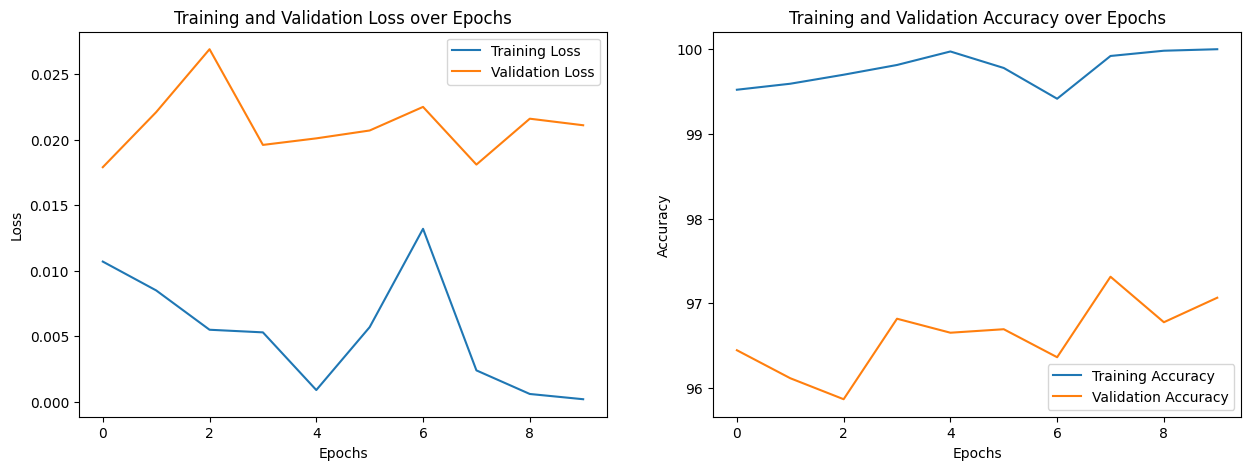

In [84]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label= 'Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label= 'Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()



In [107]:
# 1 - read image
# 2 - Transform using transform object
# 3 - predict through the model
# 4 - inverse transform by label encoder

def predict_image(image_path):
  image= Image.open('golden-retriever.jpg').convert('RGB')
  image = transform(image).to(device)
  #print(image.unsqueeze(0).shape)
  output = model(image.unsqueeze(0))

  output=torch.argmax(output, axis=1).item()
  print(output)

  return label_encoder.inverse_transform([output])

In [108]:
predict_image('golden-retriever.jpg')

0


array(['cat'], dtype=object)